In [1]:
import sys
sys.path.append('..')
from Comms_System import Comms_System, butter_lowpass, SNR_plot, SNR_plot_vanilla
import numpy as np
import matplotlib.pyplot as plt
import torch
from NetworkPytorch import train_loop
from DE_Pytorch import DE
from torchsummary import summary
from scipy import signal
from scipy.stats import norm

In [2]:
def get_data(num_symbols, sigma, lowpass=None):
    
    symbol_set = [3, 1, -1, -3,] # all symbols that we use
    symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
    m = 8
    CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, norm_h=False)

    gain_factor = np.max(np.convolve(CS.h, CS.h))
    upsampled = CS.upsample(v=False)
    Tx = np.convolve(upsampled, CS.h)
    
    if lowpass is not None:
        print('low')
        b, a = butter_lowpass(lowpass, CS.m, 4)
        Tx = signal.lfilter(b, a, upsampled)

    # Normalize signal
    Tx = Tx / np.sqrt(np.mean(np.square(Tx)))
    Tx = Tx + np.random.normal(0.0, sigma, Tx.shape)  # add gaussian noise
    
    X = torch.tensor(Tx)
    X = X.view(1, 1, -1).float() # reshape and cast to float so PyTorch understands it
    y = symbol_seq
    classes = np.array(symbol_set)
    num_classes = len(classes)

    class_idx = {v: i for i, v in enumerate(classes)}
    y_idx = np.array([class_idx[v] for v in y])
    y = torch.Tensor(y_idx)
    
    return X, y

def make_net():
    net = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64), torch.nn.Conv1d(1, 4, 8, stride=8))
    for param in net.parameters():
        param.requires_grad = False
    return net

In [3]:
# Create Data
Xtrain, ytrain = get_data(num_symbols=10000, sigma=2, lowpass=None)
Xtest, ytest = get_data(num_symbols=10000, sigma=2, lowpass=None)

# Create 1D Convolutional Neural Network with PyTorch and define optimizer and loss
NN = torch.nn.Sequential(torch.nn.Conv1d(1, 1, 64), torch.nn.Conv1d(1, 4, 8, stride=8))
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(NN.parameters(), lr=1e-3)

D = DE(objective_function=torch.nn.CrossEntropyLoss(), population_function=make_net, 
       X=Xtrain, y=ytrain, Xtest=Xtest, ytest=ytest, F=0.55, cr=0.85, use_cuda=False)
#summary(make_net(), input_size=(1, 1, 8063))

In [ ]:
# DE Training

best_agent = D.evolution(num_epochs=10000, verbose=True, print_epoch=500)
#best_agent, opt_agent = D.early_stop_training(patience=500, measure='accuracy')

D.evaluate()
acc = torch.sum(D.best_agent.to('cpu')(Xtest).argmax(axis=1) == ytest)/len(ytest)
print('Accuracy:', acc.item())

In [ ]:
norm_learned_filter = learned_filter / torch.sqrt(torch.sum(torch.square(learned_filter)))
norm_learned_filter

Using CPU
Epoch 0: 
 Train Loss: 1.5399439334869385 
 Test Loss: 1.5266846418380737


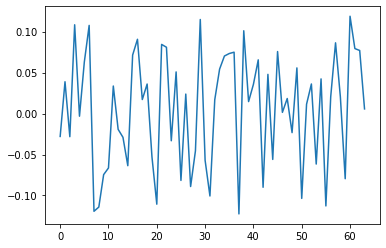

Epoch 300: 
 Train Loss: 0.9000978469848633 
 Test Loss: 0.902432918548584


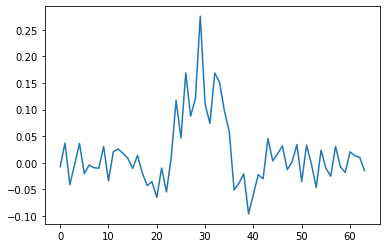

Epoch 600: 
 Train Loss: 0.8651039004325867 
 Test Loss: 0.8684356212615967


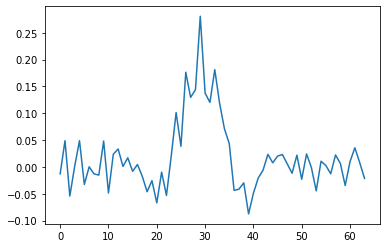

Epoch 900: 
 Train Loss: 0.8553311228752136 
 Test Loss: 0.859656572341919


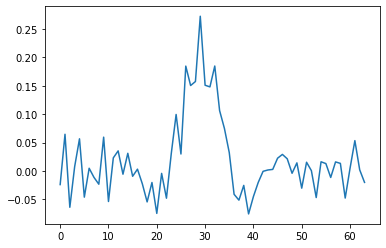

In [4]:
# Backprop Training

testcosts, traincosts = train_loop(model=NN, optimizer=optimizer, cost=criterion, Xtrain=Xtrain, ytrain=ytrain, 
                                   Xtest=Xtest, ytest=ytest, epochs=1000, eval=True, plot_iteration=300, 
                                   use_cuda=False)

In [ ]:
# Plot final learned filter
learned_filter = np.array(list(NN.parameters())[0].detach())[0][0]
plt.plot(learned_h)

In [7]:
#symbol_set = [7, 5, 3, 1, -1, -3, -5, -7] # all symbols that we use
symbol_set = [3, 1, -1, 3]
num_symbols = 100000
symbol_seq = np.random.choice(symbol_set, num_symbols, replace=True)
m = 8
CS = Comms_System(symbol_set=symbol_set, symbol_seq=symbol_seq, num_samples=m, norm_h=False)
#sigma = 1 # corresponds roughly to SNR 16 (old sigma=1)
#sigma = 0.7 # corresponds roughly to SNR 10 (old sigma=2)
#sigma = 1.06 # corresponds roughly to SNR 6.4 (old sigma=3)
SNR = 10
sigma = CS.SNRdb_to_sigma(SNR)
print(sigma)


euclid_decisions = CS.transmission(noise_level=sigma, mode='euclidean', norm_signal=False)
conv_decisions = CS.transmission(noise_level=sigma, mode='network', norm_signal=True, model=NN)

print(1 - CS.evaluate(euclid_decisions)[1])
print(1 - CS.evaluate(conv_decisions)[1])

0.7082993717348618
E: 7.997651076371556
Ratio: 79.97651076371557
E: 7.997651076371556
Ratio: 79.97651076371557
0.99998
0.93806


In [8]:
SNRdbs, euclid_error_rates, network_error_rates, error_theory = SNR_plot_vanilla(model=NN, normalized_network=True)

Avg symbol energy 4.9456
gain 7.997651076371556


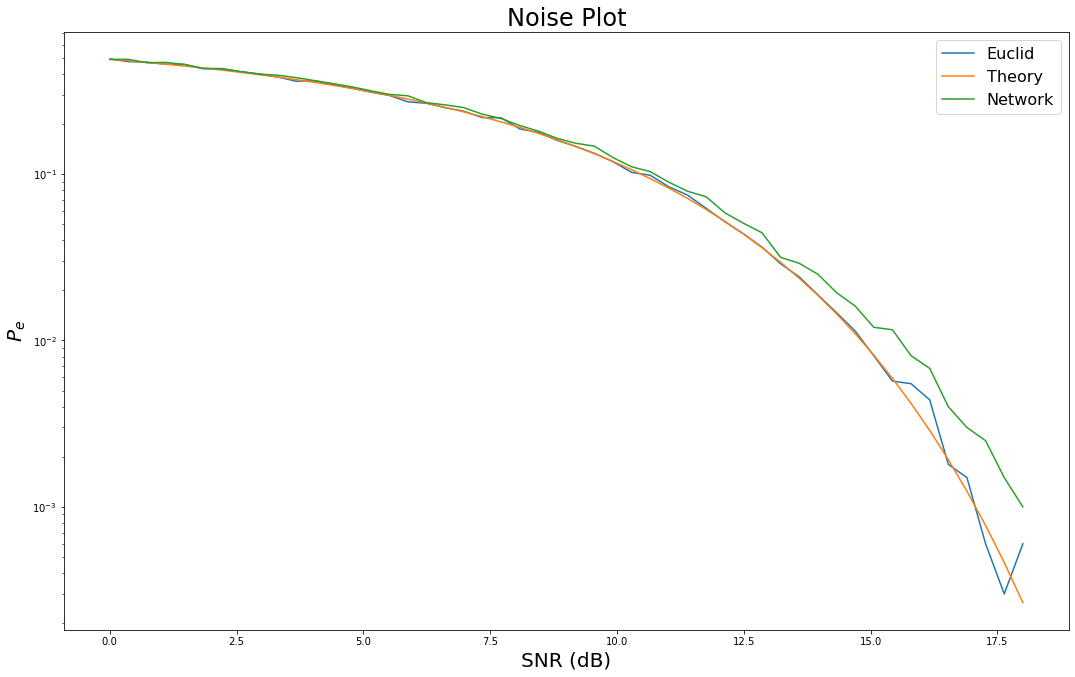

In [9]:
plt.figure(figsize=(18, 11))
plt.title('Noise Plot', fontsize=24)
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=20)
plt.semilogy(SNRdbs, euclid_error_rates)
plt.semilogy(SNRdbs, error_theory)
plt.semilogy(SNRdbs, network_error_rates)

legend = ['Euclid', 'Theory', 'Network']
plt.legend(legend, fontsize=16)
plt.show()


In [ ]:
SNRsDB, euclid_er, _, _, _, error_rates_conv, error_theory = SNR_plot(10000, lowpass=None, conv_model=NN,
                                                              norm_h=True, norm_signal=False, use_gain=False)

In [ ]:
plt.figure(figsize=(18,11))
plt.title('Noise Plot', fontsize=24)
plt.xlabel('SNR (dB)', fontsize=20)
plt.ylabel('$P_e$', fontsize=20)
num = 0
plt.semilogy(SNRsDB[num:], euclid_er[num:])
plt.semilogy(SNRsDB[num:], error_rates_conv[num:])
plt.semilogy(SNRsDB[num:], error_theory[num:])
legend = ['Euclid', 'Network Receiver', 'Theory']
legend2 = ['Euclid', 'Theory']
plt.legend(legend, fontsize=16)
plt.show()